# Net benefit analysis
In this notebook we will perform a net benefit analysis.

sources: [1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8253953/)

In [1]:
from collections import defaultdict
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv
import pandas as pd
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.model_selection import LeaveOneOut, cross_val_predict, StratifiedGroupKFold, StratifiedKFold, cross_validate
from statkit.distributions import ZeroInflatedExponential
from statkit.naive_bayes import NaiveBayesClassifier
from sklearn.metrics import recall_score
from tqdm import tqdm

In [2]:
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [3]:
# Add end-to-end package to path.
import sys
from pathlib import Path

sys.path.append(str(Path('../').absolute()))
os.chdir(".")

In [4]:
from utils import X_y, binarize, net_benefit, net_cost, npv, specificity

## Load the data and compute probabilities

In [5]:
# Discovery dataset.
hrtw_signatures = read_csv('../artifacts/hartwig_wes_signature.tsv', sep='\t', index_col=0)
X_hrtw, y_hrtw = X_y(hrtw_signatures)
not_na_hrtw = (~y_hrtw.isna())
X_hrtw, y_hrtw = X_hrtw[not_na_hrtw], y_hrtw[not_na_hrtw]

# Validation dataset.
miao = read_csv('../artifacts/miao_wes_signature.tsv', sep='\t', index_col=0)
X_miao, y_miao = X_y(miao)
not_na_miao = ~y_miao.isna()
X_miao, y_miao = X_miao[not_na_miao], y_miao[not_na_miao]

In [6]:
features = ['SBS4', 'SBS87']
clf = NaiveBayesClassifier(ZeroInflatedExponential)

repeated_runs = 50
hrtw_res = []
clfs = []
for run in tqdm(range(repeated_runs)):
    val_indcs = []
    train_indcs = []
    fold_nums = []

    splitter = StratifiedKFold(n_splits=10, random_state=None, shuffle=True)
    for idx, (tr_indcs, t_indcs) in enumerate(splitter.split(X_hrtw,y_hrtw)):
        val_indcs.append(t_indcs)
        train_indcs.append(tr_indcs)
        fold_nums.extend(len(t_indcs)*[idx])
    rrun_nums = len(fold_nums)*[run]
    train_val_splits = zip(train_indcs, val_indcs)
    hrtw_res.append(
            cross_val_predict(
                clf,
                X_hrtw[features],
                y_hrtw,
                cv=train_val_splits,
                method='predict_proba',
                verbose=0,
            )[:, 1]
        )
    train_val_splits = zip(train_indcs, val_indcs)
    models = []
    for (train, _) in train_val_splits:
        clf = NaiveBayesClassifier(ZeroInflatedExponential)
        clf.fit(X_hrtw[features].values[train], y_hrtw.values[train])
        models.append(clf)
    clfs.append(models)

100%|██████████| 50/50 [00:02<00:00, 17.57it/s]


In [7]:
# Re-train classifier on Hartwig data.
# And compute probabilities on the validation dataset (Miao et al)
miao_res = []
for cvrun in tqdm(clfs):
    for clf in cvrun:
        y_miao_proba = clf.predict_proba(X_miao[features].values)[:, 1]
        miao_res.append(y_miao_proba)     

100%|██████████| 50/50 [00:04<00:00, 11.17it/s]


# Net benefit plot


In [8]:
def get_benefit_df(res, y_actual, costs=[0,100,300,200]):
    threshold_range = np.arange(0.01,0.99,0.005)
    reslist = []
    for foldnum, fold in tqdm(enumerate(res)):
        for thr in threshold_range:
            y_pred, _ = binarize(np.array(fold), threshold=(thr, thr))
            reslist.append({'npv': npv(y_actual, y_pred),
                            'net_benefit_treated': net_benefit(y_actual, y_pred, thr, mode='model', treated=True),
                            'net_benefit_untreated': net_benefit(y_actual, y_pred, thr, mode='model', treated=False),
                            'net_benefit_treated_all': net_benefit(y_actual, y_pred, thr, mode='all', treated=True),
                            'net_benefit_untreated_all': net_benefit(y_actual, y_pred, thr, mode='all', treated=False),
                            'net_benefit_treated_none': net_benefit(y_actual, y_pred, thr, mode='none', treated=True),
                            'net_benefit_untreated_none': net_benefit(y_actual, y_pred, thr, mode='none', treated=False),
                            'net_benefit_treated_oracle': net_benefit(y_actual, y_pred, thr, mode='oracle', treated=True),
                            'net_benefit_untreated_oracle': net_benefit(y_actual, y_pred, thr, mode='oracle', treated=False),
                            'net_cost': net_cost(y_actual, y_pred, thr, cost_tn=costs[0], cost_tp=costs[1], cost_fn=costs[2], cost_fp=costs[3]),
                            'net_cost_all': net_cost(y_actual, y_pred, thr, cost_tn=costs[0], cost_tp=costs[1], cost_fn=costs[2], cost_fp=costs[3], mode='all'),
                            'net_cost_none': net_cost(y_actual, y_pred, thr, cost_tn=costs[0], cost_tp=costs[1], cost_fn=costs[2], cost_fp=costs[3], mode='none'),
                            'net_cost_oracle': net_cost(y_actual, y_pred, thr, cost_tn=costs[0], cost_tp=costs[1], cost_fn=costs[2], cost_fp=costs[3], mode='oracle'),
                            'specificity': specificity(y_actual, y_pred),
                            'sensitivity': recall_score(y_actual, y_pred),
                            'number_avoided_model': np.mean((y_pred<thr) & (y_actual==0))*100,
                            'number_avoided_wrong': np.mean((y_pred<thr) & (y_actual==1))*100,
                            'number_avoided_oracle': np.mean(y_actual==0)*100,
                            'threshold': thr,
                            'fold': foldnum}) 
    reslist_df = pd.DataFrame(reslist)

    reslist_df['net_benefit_combined'] = reslist_df['net_benefit_treated'] + reslist_df['net_benefit_untreated']
    reslist_df['net_benefit_combined_none'] = reslist_df['net_benefit_treated_none'] + reslist_df['net_benefit_untreated_none']
    reslist_df['net_benefit_combined_all'] = reslist_df['net_benefit_treated_all'] + reslist_df['net_benefit_untreated_all']
    reslist_df['net_benefit_combined_oracle'] = reslist_df['net_benefit_treated_oracle'] + reslist_df['net_benefit_untreated_oracle']

    return reslist_df

In [9]:
miao_benefit_df = get_benefit_df(miao_res, y_miao)
hrtw_benefit_df = get_benefit_df(hrtw_res, y_hrtw)

500it [04:12,  1.98it/s]
50it [00:27,  1.84it/s]


In [10]:
miao_benefit_df

npv  net_benefit_treated  net_benefit_untreated  \
0      0.000000             0.476244               0.000000   
1      0.000000             0.473585               0.000000   
2      0.000000             0.470899               0.000000   
3      0.000000             0.468186               0.000000   
4      0.000000             0.465445               0.000000   
...         ...                  ...                    ...   
97995  0.538462             0.037037               0.502399   
97996  0.538462             0.037037               0.504773   
97997  0.538462             0.037037               0.507123   
97998  0.538462             0.037037               0.509448   
97999  0.538462             0.037037               0.511750   

       net_benefit_treated_all  net_benefit_untreated_all  \
0                     0.476244                 -47.148148   
1                     0.473585                 -31.098765   
2                     0.470899                 -23.074074   
3                     0.468186                 -18.259259   
4                     0.465445                 -15.049383   
...                        ...                        ...   
97995               -13.814815                   0.501055   
97996               -16.283951                   0.503627   
97997               -19.740741                   0.506173   
97998               -24.925926                   0.508692   
97999               -33.567901                   0.511186   

       net_benefit_treated_none  net_benefit_untreated_none  \
0                             0                           0   
1                             0                           0   
2                             0                           0   
3                             0                           0   
4                             0                           0   
...                         ...                         ...   
97995                         0                           0   
97996                         0                           0   
97997                         0                           0   
97998                         0                           0   
97999                         0                           0   

       net_benefit_treated_oracle  net_benefit_untreated_oracle  net_cost  \
0                        0.481481                      0.518519  0.253086   
1                        0.481481                      0.518519  0.253086   
2                        0.481481                      0.518519  0.253086   
3                        0.481481                      0.518519  0.253086   
4                        0.481481                      0.518519  0.253086   
...                           ...                           ...       ...   
97995                    0.481481                      0.518519  0.228395   
97996                    0.481481                      0.518519  0.228395   
97997                    0.481481                      0.518519  0.228395   
97998                    0.481481                      0.518519  0.228395   
97999                    0.481481                      0.518519  0.228395   

       ...  sensitivity  number_avoided_model  number_avoided_wrong  \
0      ...     1.000000              0.000000              0.000000   
1      ...     1.000000              0.000000              0.000000   
2      ...     1.000000              0.000000              0.000000   
3      ...     1.000000              0.000000              0.000000   
4      ...     1.000000              0.000000              0.000000   
...    ...          ...                   ...                   ...   
97995  ...     0.076923             51.851852             44.444444   
97996  ...     0.076923             51.851852             44.444444   
97997  ...     0.076923             51.851852             44.444444   
97998  ...     0.076923             51.851852             44.444444   
97999  ...     0.076923             51.851852             4

In [11]:
# integrated benefit
step = 0.005

benefits = defaultdict(lambda: defaultdict(list))

for _fold in miao_benefit_df.fold.unique():
    sum_all = 0.5*step*(miao_benefit_df[miao_benefit_df.fold==_fold]['net_benefit_combined_all'][1:]
                + miao_benefit_df[miao_benefit_df.fold==_fold]['net_benefit_combined_all'][:-1]).sum()

    sum_clf = 0.5*step*(miao_benefit_df[miao_benefit_df.fold==_fold]['net_benefit_combined'][1:]
                + miao_benefit_df[miao_benefit_df.fold==_fold]['net_benefit_combined'][:-1]).sum()

    sum_oracle = 0.5*step*(miao_benefit_df[miao_benefit_df.fold==_fold]['net_benefit_combined_oracle'][1:]
                + miao_benefit_df[miao_benefit_df.fold==_fold]['net_benefit_combined_oracle'][:-1]).sum()

    sum_none = 0.5*step*(miao_benefit_df[miao_benefit_df.fold==_fold]['net_benefit_combined_none'][1:]
                + miao_benefit_df[miao_benefit_df.fold==_fold]['net_benefit_combined_none'][:-1]).sum()
    benefits['miao']['all'].append(sum_all)
    benefits['miao']['clf'].append(sum_clf)
    benefits['miao']['oracle'].append(sum_oracle)
    benefits['miao']['none'].append(sum_none)


# integrated benefit
for _fold in hrtw_benefit_df.fold.unique():

    sum_all = 0.5*step*(hrtw_benefit_df[hrtw_benefit_df.fold==_fold]['net_benefit_combined_all'][1:]
                + hrtw_benefit_df[hrtw_benefit_df.fold==_fold]['net_benefit_combined_all'][:-1]).sum()

    sum_clf = 0.5*step*(hrtw_benefit_df[hrtw_benefit_df.fold==_fold]['net_benefit_combined'][1:]
                + hrtw_benefit_df[hrtw_benefit_df.fold==_fold]['net_benefit_combined'][:-1]).sum()

    sum_oracle = 0.5*step*(hrtw_benefit_df[hrtw_benefit_df.fold==_fold]['net_benefit_combined_oracle'][1:]
                + hrtw_benefit_df[hrtw_benefit_df.fold==_fold]['net_benefit_combined_oracle'][:-1]).sum()

    sum_none = 0.5*step*(hrtw_benefit_df[hrtw_benefit_df.fold==_fold]['net_benefit_combined_none'][1:]
                + hrtw_benefit_df[hrtw_benefit_df.fold==_fold]['net_benefit_combined_none'][:-1]).sum()

    benefits['hartwig']['all'].append(sum_all)
    benefits['hartwig']['clf'].append(sum_clf)
    benefits['hartwig']['oracle'].append(sum_oracle)
    benefits['hartwig']['none'].append(sum_none)

In [12]:
hartwig_int_benefit = np.quantile(np.array(benefits['hartwig']['clf']), [0.25, 0.5, 0.75])
miao_int_benefit = np.quantile(np.array(benefits['miao']['clf']), [0.25, 0.5, 0.75])

print(f"Hartwig benefit:{hartwig_int_benefit}, Miao benefit:{miao_int_benefit}")

print(f"Hartwig benefit all:{np.quantile(np.array(benefits['hartwig']['all']), [0.25, 0.5, 0.75])},\
Miao benefit all:{np.quantile(np.array(benefits['miao']['all']), [0.25, 0.5, 0.75])}")

print(f"Hartwig benefit none:{np.quantile(np.array(benefits['hartwig']['none']), [0.25, 0.5, 0.75])},\
Miao benefit all:{np.quantile(np.array(benefits['miao']['none']), [0.25, 0.5, 0.75])}")

print(f"Hartwig benefit oracle:{np.quantile(np.array(benefits['hartwig']['oracle']), [0.25, 0.5, 0.75])},\
Miao benefit all:{np.quantile(np.array(benefits['miao']['oracle']), [0.25, 0.5, 0.75])}")

Hartwig benefit:[0.3692899  0.37390582 0.37895281], Miao benefit:[0.28525718 0.29037523 0.29544244]
Hartwig benefit all:[-2.21668928 -2.21668928 -2.21668928],Miao benefit all:[-2.24767174 -2.24767174 -2.24767174]
Hartwig benefit none:[0. 0. 0.],Miao benefit all:[0. 0. 0.]
Hartwig benefit oracle:[0.97 0.97 0.97],Miao benefit all:[0.97 0.97 0.97]


In [25]:
def plot_benefit(df, title="Benefit plots", file_prefix = "", sample_frac=0.9, out_type='png'):

    sample_idx = df.sample(frac=sample_frac).index

    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(24, 18))
    sns.scatterplot(data=df.loc[sample_idx], x='threshold', 
                        y='net_benefit_treated', color='green', 
                    alpha=1, label='model', ax=ax[0,0])
    ax[0,0].plot(df['threshold'], df['net_benefit_treated_none'],
            color='black',  alpha=1, label='none', linestyle='--', linewidth=5)
    ax[0,0].scatter(df.loc[sample_idx, 'threshold'], 
                    df.loc[sample_idx, 'net_benefit_treated_all'],
            color='black',  alpha=1, label='all', marker='+', s=250)
    ax[0,0].plot(df['threshold'], df['net_benefit_treated_oracle'],
            color='black',  alpha=1, label='oracle', linestyle=':', linewidth=5)
    ax[0,0].legend(fontsize=18)
    ax[0,0].set_xlim(0,1)
    ax[0,0].set_ylim(-0.25,0.5)

    ax[0,0].set_xlabel('Decision threshold', fontsize=22)
    ax[0,0].set_ylabel('Net benefit for the treated', fontsize=22)

    '''
    sns.scatterplot(data=df, x='threshold', y='net_benefit_untreated', color='green', 
                    alpha=1, label='model', ax=ax[0,1])
    ax[0,1].plot(df['threshold'], df['net_benefit_untreated_none'], 
            color='black',  alpha=1, label='none', linestyle='--', linewidth=5)
    ax[0,1].scatter(df.loc[sample_idx, 'threshold'], 
                    df.loc[sample_idx, 'net_benefit_untreated_all'], 
            color='black',  alpha=1, label='all', marker='+', s=250)
    ax[0,1].plot(df['threshold'], df['net_benefit_untreated_oracle'],
            color='black',  alpha=1,label='oracle', linestyle=':', linewidth=5)
    ax[0,1].legend(fontsize=18)
    ax[0,1].set_xlim(0,1)
    ax[0,1].set_ylim(-0.5,0.7)
    ax[0,1].set_xlabel('Decision threshold', fontsize=22)
    ax[0,1].set_ylabel('Net benefit for the untreated', fontsize=22)
    '''
    sns.scatterplot(data=df.loc[sample_idx], x='threshold',
                        y='number_avoided_model', color='green', 
                    alpha=1, label='True positive', ax=ax[0,1])
    ax[0,1].plot(df['threshold'], df['number_avoided_oracle'],
            color='black',  alpha=1, label='oracle', linestyle=':', linewidth=5)
    ax[0,1].scatter(df.loc[sample_idx, 'threshold'], df.loc[sample_idx, 'number_avoided_wrong'],
            color='red',  alpha=1,label='False positive')
    ax[0,1].legend(fontsize=18)
    ax[0,1].set_xlim(0,1)
    ax[0,1].set_ylim(0,75)
    ax[0,1].set_xlabel('Decision threshold', fontsize=22)
    ax[0,1].set_ylabel('immunotherapies avoided/100 patients', fontsize=22)


    sns.scatterplot(data=df.loc[sample_idx], x='threshold', 
                        y='net_benefit_combined',color='green',
                    alpha=1, label='model', ax=ax[1,0])
    ax[1,0].plot(df['threshold'], df['net_benefit_combined_none'],
                color='black',  alpha=1, label='none', linestyle='--', linewidth=5)
    ax[1,0].scatter(df.loc[sample_idx, 'threshold'],
                   df.loc[sample_idx, 'net_benefit_combined_all'],
            color='black',  alpha=1, label='all', marker='+', s=250)
    ax[1,0].plot(df['threshold'], df['net_benefit_combined_oracle'],
                color='black',  alpha=1, label='oracle', linestyle=':', linewidth=5)
    ax[1,0].legend(fontsize=18)
    ax[1,0].set_xlim(0,1.)
    ax[1,0].set_ylim(-0.75,1.1)
    ax[1,0].set_xlabel('Decision threshold', fontsize=22)
    ax[1,0].set_ylabel('Combined net benefit', fontsize=22)

    
    sns.scatterplot(data=df.loc[sample_idx], x='threshold', y='net_cost', color='green',  
                    alpha=1, label='model')
    ax[1,1].plot(df['threshold'], df['net_cost_none'],  linestyle='--', 
            color='black', alpha=1,label='none', linewidth=5)
    ax[1,1].scatter(df.loc[sample_idx, 'threshold'],
                    df.loc[sample_idx, 'net_cost_all'], 
            color='black',  alpha=1, label='all', marker='+', s=250)
    ax[1,1].plot(df['threshold'], df['net_cost_oracle'], linestyle=':', 
            color='black', alpha=1,label='oracle', linewidth=5)
    ax[1,1].legend(loc='lower left', fontsize=18)
    ax[1,1].set_xlim(0,1.)
    #ax[1,1].set_ylim(0.1,0.3)
    ax[1,1].set_xlabel('Decision threshold', fontsize=22)
    ax[1,1].set_ylabel('Net cost', fontsize=22)
    
    plt.ioff()
    if out_type=='eps':
        plt.savefig(f"../figures/net_benefit_{file_prefix}.eps", format='eps', dpi=500)
    elif out_type=='png':
        plt.savefig(f"../figures/net_benefit_{file_prefix}.png", format='png', dpi=500)

In [16]:
def get_proba_df(res_list, actual):
    df = pd.DataFrame()
    for fold, res in enumerate(res_list):
        dat = np.transpose(np.vstack([actual,res]))
        df_fold = pd.DataFrame(dat, 
                                columns=['actual', 'proba'])
        df_fold['fold'] = fold
        df = pd.concat([df, df_fold])
    return df

In [17]:
hartwig_proba_df = get_proba_df(list(hrtw_res), y_hrtw.values)
miao_proba_df = get_proba_df(list(miao_res), y_miao.values)

In [18]:
def get_calibration(df, nbins=10):
    calibration_df = pd.DataFrame()
    for _fold  in df.fold.unique():
        p_true,p_pred = calibration_curve(df[df.fold==_fold]['actual'], 
                                          df[df.fold==_fold]['proba'], 
                                          n_bins=nbins, 
                                          strategy='quantile')
        calibration_df = pd.concat([calibration_df, 
                         pd.DataFrame({'p_true':p_true, 'p_pred':p_pred, 'fold':_fold})])
    return calibration_df

100%|██████████| 50/50 [00:00<00:00, 164.67it/s]


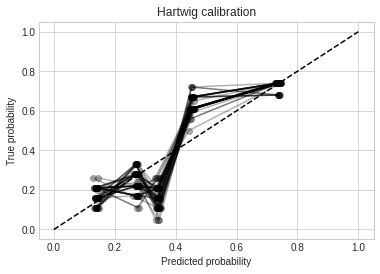

In [19]:
cal_hartwig = get_calibration(hartwig_proba_df, nbins=5)
cal_hartwig.p_true = cal_hartwig.p_true.round(2)

for _fold in tqdm(cal_hartwig.fold.unique()):
    plt.plot(cal_hartwig[cal_hartwig.fold==_fold].p_pred, cal_hartwig[cal_hartwig.fold==_fold].p_true, 
            color='black', alpha=0.3)
    plt.scatter(cal_hartwig[cal_hartwig.fold==_fold].p_pred, cal_hartwig[cal_hartwig.fold==_fold].p_true, 
            color='black', alpha=0.3)

plt.plot([0,1], [0,1], color='black', linestyle='--')
plt.xlabel("Predicted probability")
plt.ylabel("True probability")
plt.title("Hartwig calibration")
plt.savefig("../figures/hartwig_calibration.png", 
            bbox_inches='tight', dpi=500)
plt.ioff()
    


100%|██████████| 500/500 [00:03<00:00, 165.80it/s]


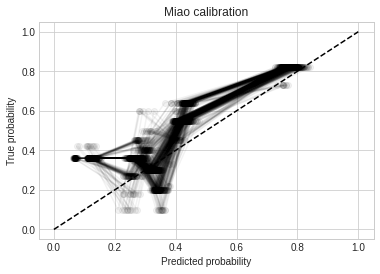

In [20]:
cal_miao = get_calibration(miao_proba_df, nbins=5)
cal_miao.p_true = cal_miao.p_true.round(2)

for _fold in tqdm(cal_miao.fold.unique()):
    plt.plot(cal_miao[cal_miao.fold==_fold].p_pred, cal_miao[cal_miao.fold==_fold].p_true, 
            color='black', alpha=0.05)
    plt.scatter(cal_miao[cal_miao.fold==_fold].p_pred, cal_miao[cal_miao.fold==_fold].p_true, 
            color='black', alpha=0.05)

plt.plot([0,1], [0,1], color='black', linestyle='--')
plt.xlabel("Predicted probability")
plt.ylabel("True probability")
plt.title("Miao calibration")
plt.savefig("../figures/miao_calibration.png", 
            bbox_inches='tight', dpi=500)
plt.ioff()


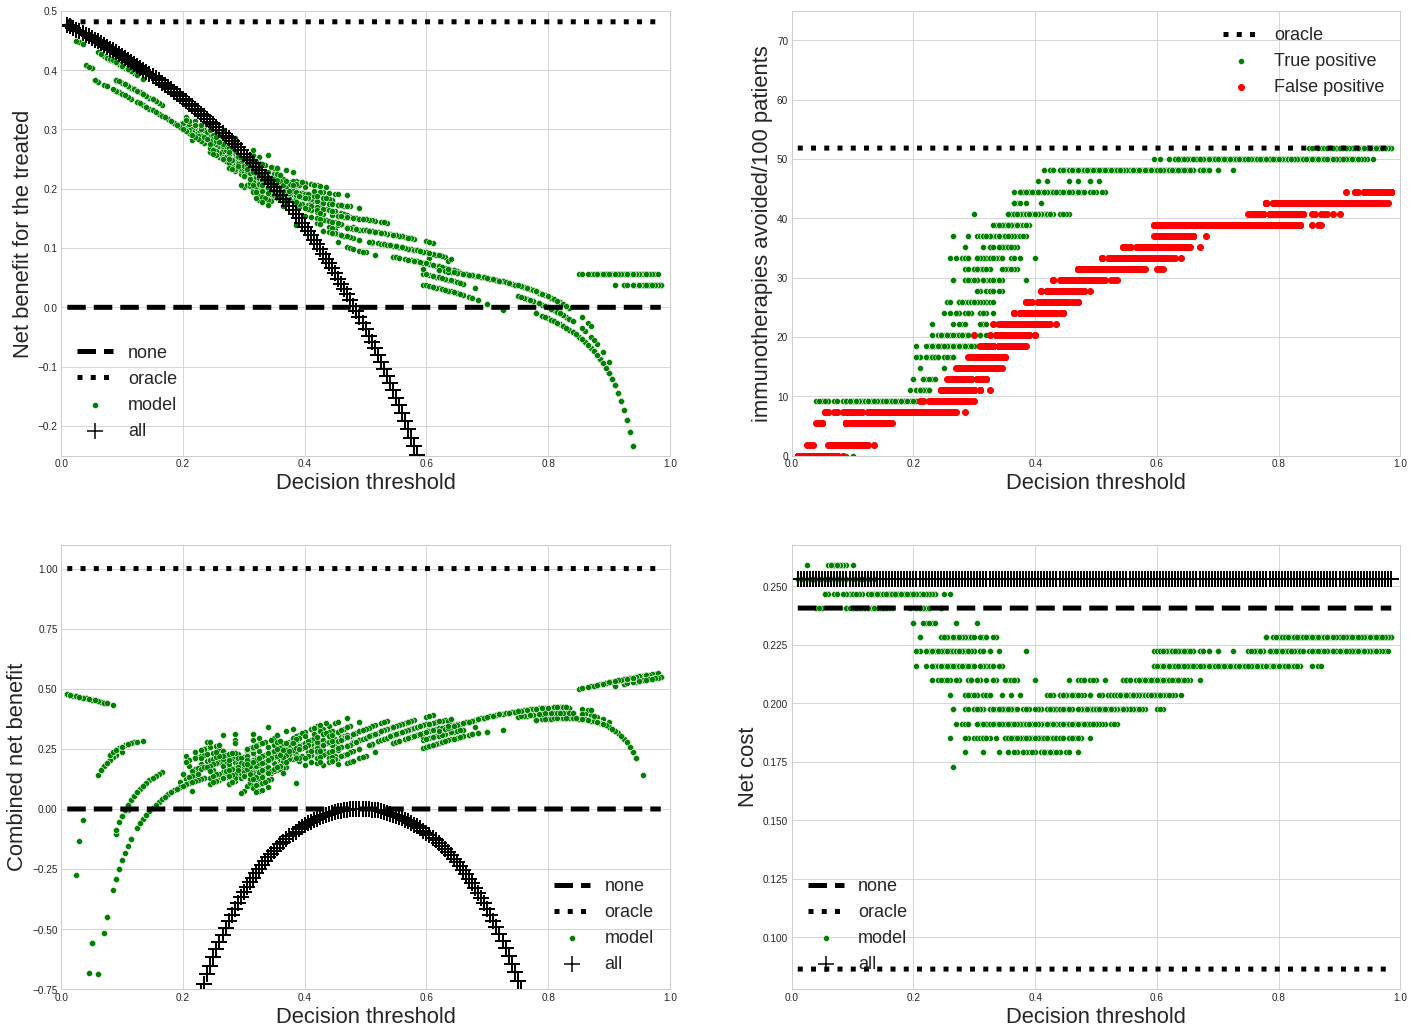

In [31]:
plot_benefit(miao_benefit_df,title="Hartwig benefit plots", 
             file_prefix="Hartwig", sample_frac=0.03, out_type='eps')

# Negative predictive value versus specificity


In [50]:
def plot_npv(df):
    fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(24, 20))
    sns.scatterplot(data=df, x='npv', y='net_benefit_treated', color='black', alpha=0.5, label='model', ax=ax[0,0])
    sns.scatterplot(data=df, x='npv', y='net_benefit_treated_none', color='red',  alpha=0.5,label='none', ax=ax[0,0])
    sns.scatterplot(data=df, x='npv', y='net_benefit_treated_all', color='green',  alpha=0.5,label='all',  ax=ax[0,0])
    sns.scatterplot(data=df, x='npv', y='net_benefit_treated_oracle', color='blue',  alpha=0.5,label='oracle', ax=ax[0,0])
    ax[0,0].legend()
    ax[0,0].set_xlim(0.6,1.0)
    ax[0,0].set_ylim(-1,1)


    sns.scatterplot(data=df, x='npv', y='net_benefit_untreated', color='black',  alpha=0.5, label='model', ax=ax[0,1])
    sns.scatterplot(data=df, x='npv', y='net_benefit_untreated_none', color='red',  alpha=0.5, label='none', ax=ax[0,1])
    sns.scatterplot(data=df, x='npv', y='net_benefit_untreated_all', color='green',  alpha=0.5, label='all', ax=ax[0,1])
    sns.scatterplot(data=df, x='npv', y='net_benefit_untreated_oracle', color='blue',  alpha=0.5,label='oracle', ax=ax[0,1])
    ax[0,1].legend()
    ax[0,1].set_xlim(0.6,1.0)
    ax[0,1].set_ylim(-10,1)

    sns.scatterplot(data=df, x='npv', y='net_benefit_combined', color='black',  alpha=0.5,label='model', ax=ax[1,0])
    sns.scatterplot(data=df, x='npv', y='net_benefit_combined_none', color='red',  alpha=0.5,label='none', ax=ax[1,0])
    sns.scatterplot(data=df, x='npv', y='net_benefit_combined_all', color='green',  alpha=0.5,label='all', ax=ax[1,0])
    sns.scatterplot(data=df, x='npv', y='net_benefit_combined_oracle', color='blue',  alpha=0.5,label='oracle', ax=ax[1,0])
    ax[1,0].legend()
    ax[1,0].set_xlim(0.6,1.0)
    ax[1,0].set_ylim(-10,1.5)

    sns.scatterplot(data=df, x='npv', y='net_cost', color='black',  alpha=0.5,label='model', ax=ax[1,1])
    sns.scatterplot(data=df, x='npv', y='net_cost_none', color='red',  alpha=0.5,label='none', ax=ax[1,1])
    sns.scatterplot(data=df, x='npv', y='net_cost_all', color='green',  alpha=0.5,label='all', ax=ax[1,1])
    sns.scatterplot(data=df, x='npv', y='net_cost_oracle', color='blue', alpha=0.5,label='oracle', ax=ax[1,1])
    ax[1,1].legend()
    ax[1,1].set_xlim(0.6,1.0)
    ax[1,1].set_ylim(0.15,0.26)

    df['sens_spec_ratio'] = df.sensitivity / (1-df.specificity)
    sns.scatterplot(data=df, x='threshold', y='sens_spec_ratio', hue='npv',  alpha=0.5,label='model', ax=ax[2,0])
    ax[2,0].set_xlim(0.0,1.0)
    #ax[2,0].set_ylim(0.15,0.26)
    sns.scatterplot(data=df, x='threshold', y='specificity', hue='npv',  alpha=0.5,label='model', ax=ax[2,1])


    ax[0,0].set_title("NPV - net benefit")
    ax[0,1].set_title("Untreated  - net benefit")
    ax[1,0].set_title("Combined  - net benefit")
    ax[1,1].set_title("Financial Cost curves")
    ax[2,0].set_title("Threshold - sensitive/(1-specificity)")
    ax[2,1].set_title("Threshold - specificity")


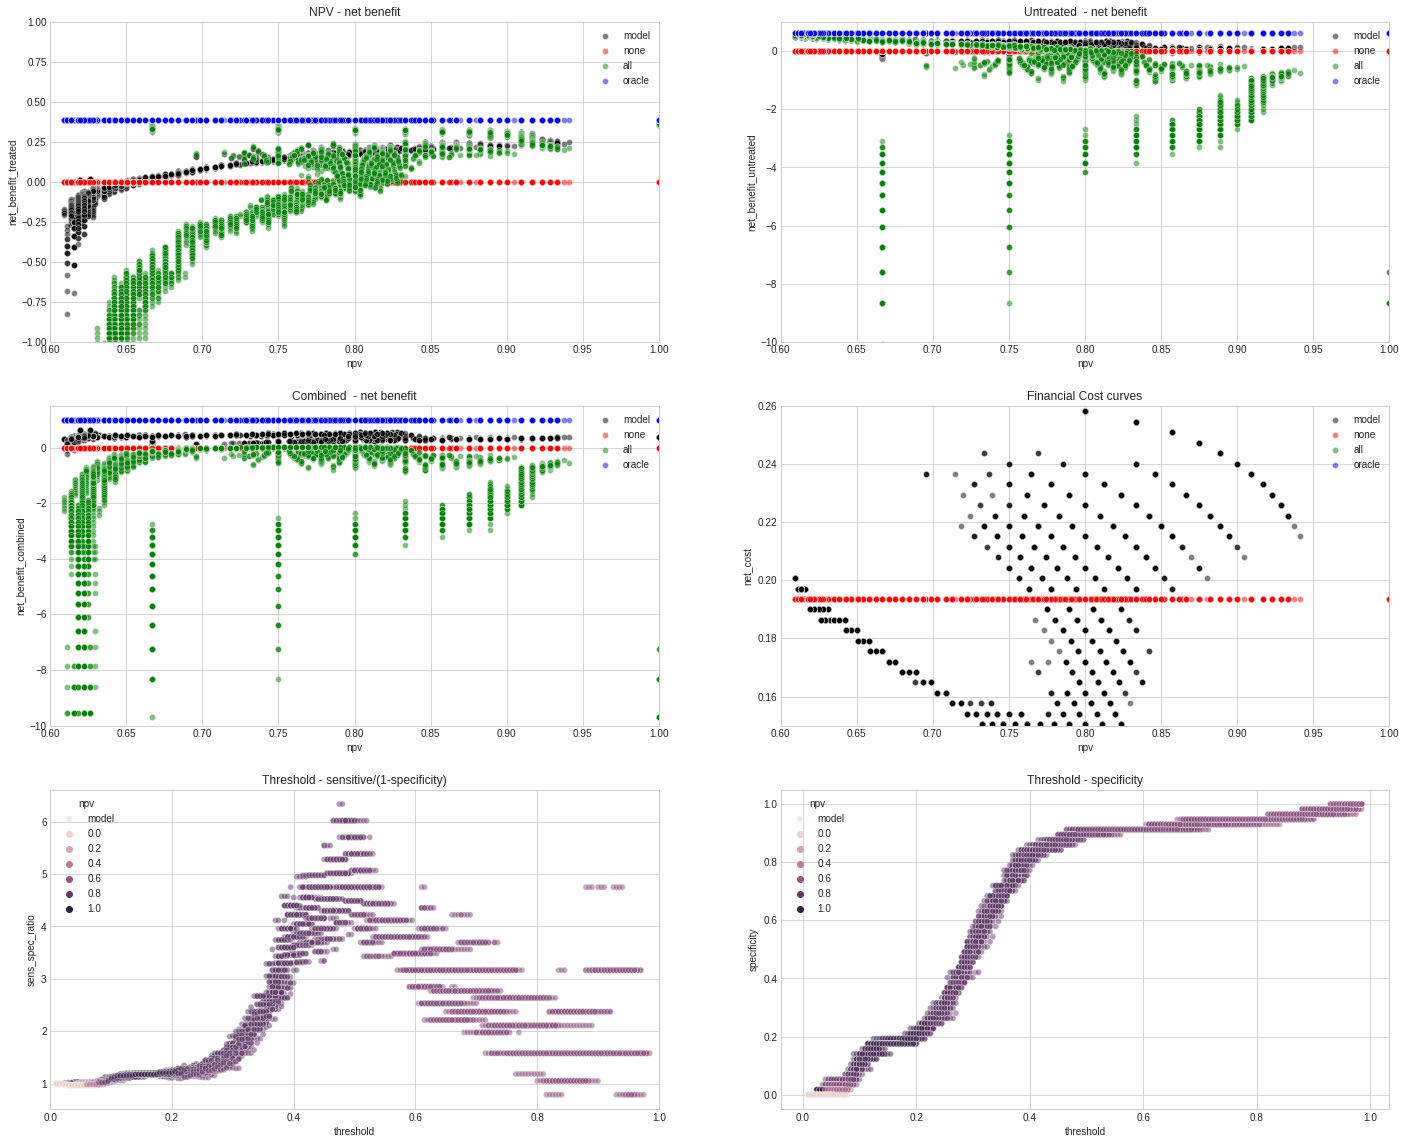

In [51]:
plot_npv(hrtw_benefit_df)

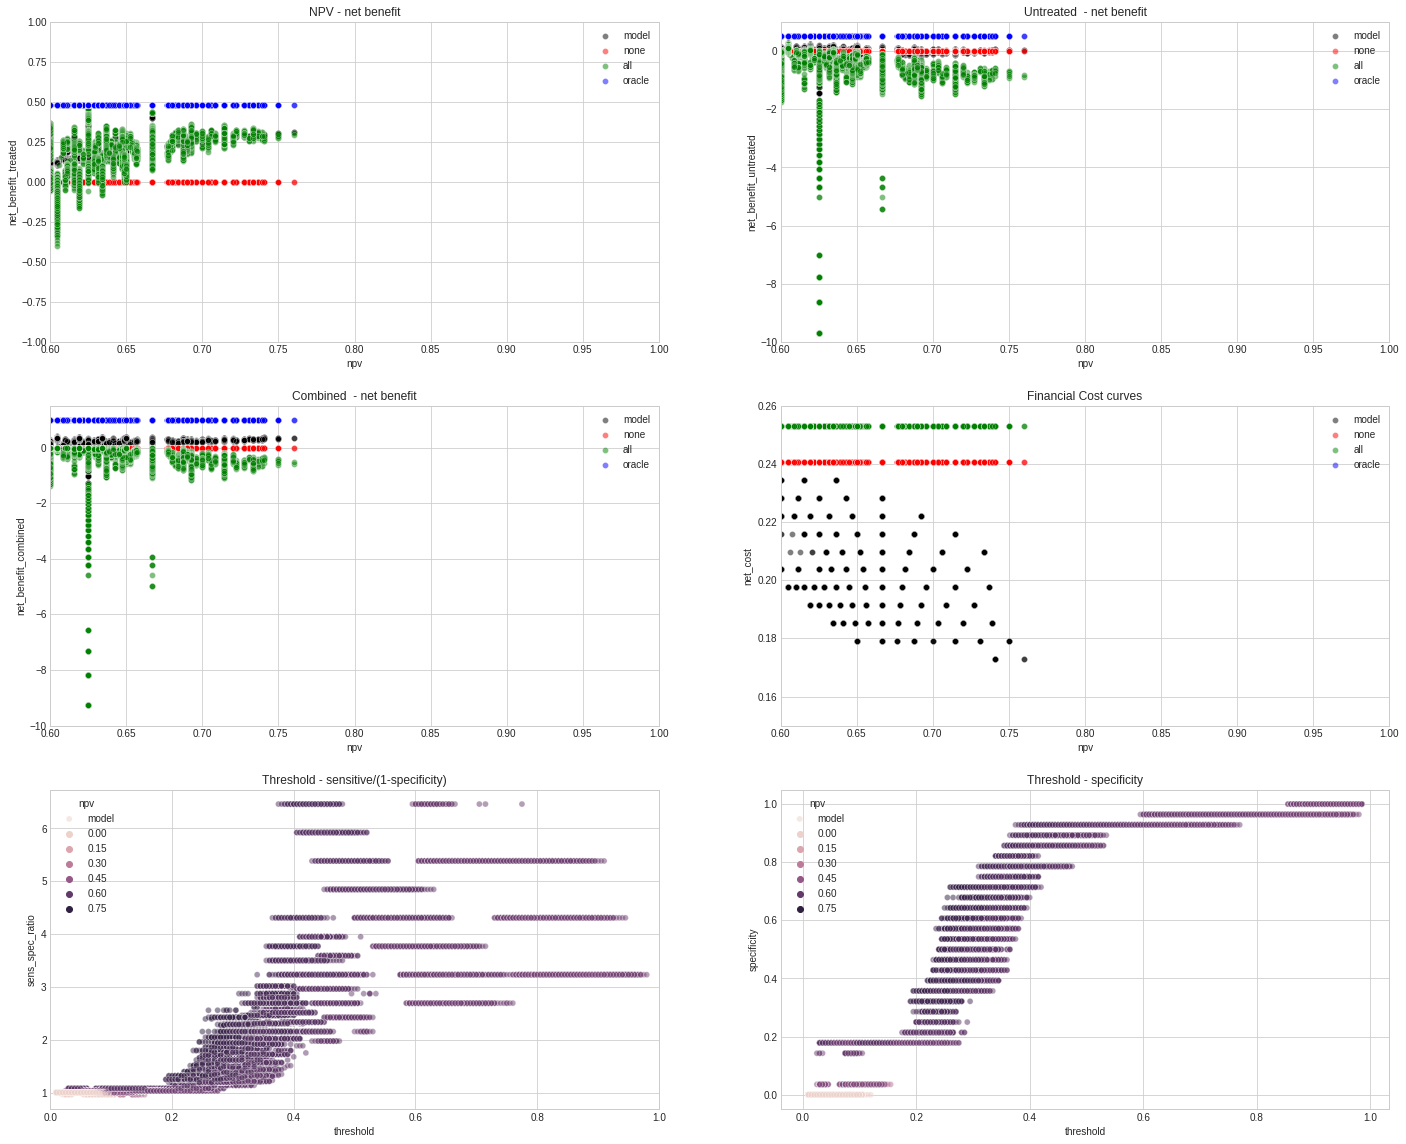

In [52]:
plot_npv(miao_benefit_df)

# Ideally 
* we do not use the threshold directly but rather use the calibrated values, i.e. the actual proba we expect based on a calibration curve
* we also visualise the ratio of the sensitivity/(1-specificity) versus the (real) proba
* we should express the net benefit with respect to the baseline protocol